# 🧼 Prétraitement des données brutes Fiverr

Ce notebook correspond à la phase de **pré-processing** du dataset Fiverr téléchargé via Kaggle. Il prépare les données brutes à des fins d’analyse ou de modélisation, en appliquant un nettoyage et une structuration adaptés.

## 🎯 Objectifs
- Analyser la structure initiale du fichier
- Supprimer les colonnes non pertinentes ou vides
- Nettoyer les chaînes de caractères et corriger les valeurs incohérentes
- Convertir les types de données (ex. : `Prix`, `Evaluation`)
- Exporter un fichier prêt à l’analyse : `fiverr-data-gigs-cleaned.csv`

✅ **Compétences mobilisées :**  
- Bloc 3 — C2 : Préparer les données pour l’analyse  
- Bloc 5 — C1 : Préparer des données non structurées

---
# Sommaire

* ## 1. Import des bibliothèques nécessaires  
   * ### 1.1. Choix et justification  
   * ### 1.2. Script d'import des bibliothèques

* ## 2. Récupération des données FIVERR sur Kaggle  
   * ### 2.1. Pourquoi automatiser le téléchargement ?  
   * ### 2.2. Résultat attendu  
   * ### 2.3. Script de téléchargement

* ## 3. Chargement des données brutes Fiverr dans un DataFrame Pandas  
   * ### 3.1. Pourquoi cette étape maintenant ?  
   * ### 3.2. Résultat attendu  
   * ### 3.3. Script de chargement du Dataframe

* ## 4. Renommage des colonnes du DataFrame  
   * ### 4.1. Pourquoi cette étape maintenant ?  
   * ### 4.2. Résultat attendu  
   * ### 4.3. Script de renommage des colonnes

* ## 5. Nettoyage et formatage de la colonne 'Prix'  
   * ### 5.1. Pourquoi cette étape maintenant ?  
   * ### 5.2. Résultat attendu  
   * ### 5.3. Script de nettoyage et formatage

* ## 6. Traitement de la colonne "gigrating" : Evaluation et nombre d'évaluation  
   * ### 6.1. Pourquoi cette étape maintenant ?  
   * ### 6.2. Résultat attendu  
   * ### 6.3. Script de traitement de la colonne "gigrating"

* ## 7. Suppression de la colonne "gigrating"  
   * ### 7.1. Pourquoi cette étape maintenant ?  
   * ### 7.2. Résultat attendu  
   * ### 7.3. Script de suppression de la colonne "gigrating"

* ## 8. Analyse exploratoire initiale du dataset  
   * ### 8.1. Pourquoi cette étape maintenant ?  
   * ### 8.2. Résultat attendu  
      * #### 8.2.1. Dimensions et types  
      * #### 8.2.2. Valeurs manquantes  
      * #### 8.2.3. Doublons  
   * ### 8.3. Script d'analyse exploratoire

* ## 9. Analyse exploratoire initiale du dataset (Suite 1)  
   * ### 9.1. Pourquoi cette étape maintenant ?  
   * ### 9.2. Résultat attendu  
      * #### 9.2.1. Statistiques descriptives  
      * #### 9.2.2. Valeurs uniques par colonne  
   * ### 9.3. Script d'analyse exploratoire (Suite 1)

* ## 10. Analyse exploratoire initiale du dataset (Suite 2)
   * ### 10.1. Pourquoi cette étape maintenant ?
   * ### 10.2. Résultat attendu
      * #### 10.2.1. Analyse des valeurs manquantes
   * ### 10.3. Script d'analyse exploratoire (Suite 2)

* ## 11. Analyse exploratoire initiale du dataset (Suite 3)  
   * ### 11.1. Pourquoi cette étape maintenant ?  
   * ### 11.2. Résultat attendu  
      * #### 11.2.1. Analyse des colonnes incomplète  
   * ### 11.3. Script d'analyse exploratoire (Suite 3)

* ## 11. Analyse exploratoire initiale du dataset (Suite 3)  
   * ### 11.1. Pourquoi cette étape maintenant ?  
   * ### 11.2. Résultat attendu  
      * #### 11.2.1. Analyse des colonnes incomplète  
   * ### 11.3. Script d'analyse exploratoire (Suite 3)

* ## 12. Analyse exploratoire initiale du dataset (Suite 4)  
   * ### 12.1. Pourquoi cette étape maintenant ?  
   * ### 12.2. Résultat attendu  
      * #### 12.2.1. Analyse des valeurs extrêmes (outliers)  
   * ### 12.3. Script d'analyse exploratoire (Suite 4)

* ## 13. Analyse exploratoire initiale du dataset (Suite 5)  
   * ### 13.1. Pourquoi cette étape maintenant ?  
   * ### 13.2. Résultat attendu  
      * #### 13.2.1. Analyse de distribution des variables numériques  
   * ### 13.3. Script d'analyse exploratoire (Suite 5)

* ## 14. Analyse exploratoire initiale du dataset (Suite 6)  
   * ### 14.1. Pourquoi cette étape maintenant ?  
   * ### 14.2. Résultat attendu  
      * #### 14.2.1. Analyse de la répartition des niveaux de vendeur  
   * ### 14.3. Script d'analyse exploratoire (Suite 6)

* ## 15. Analyse exploratoire initiale du dataset (Suite 7)  
   * ### 15.1. Pourquoi cette étape maintenant ?  
   * ### 15.2. Résultat attendu  
      * #### 15.2.1. Analyse de la répartition des niveaux de vendeur  
   * ### 15.3. Script d'analyse exploratoire (Suite 7)

* ## 16. Imputation des valeurs manquantes dans la colonne "Niveau" avec KNN 
   * ### 16.1. Pourquoi cette étape maintenant ?  
   * ### 16.2. Résultat attendu  
   * ### 16.3. Script d'Imputation

* ## 17. Nettoyage des données
   * ### 17.1. Pourquoi cette étape maintenant ?  
   * ### 17.2. Résultat attendu  
   * ### 17.3. Script de nettoyage

* ## 18. Visualisation des distributions
   * ### 18.1. Pourquoi cette étape maintenant ?  
   * ### 18.2. Résultat attendu  
   * ### 18.3. Script de la visualisation des distributions

* ## 19. Export du fichier nettoyé
   * ### 18.1. Pourquoi cette étape maintenant ?  
   * ### 18.2. Résultat attendu  
   * ### 18.3. Script de l'export du fichier nettoyé

* ## 20. Conclusion du prétraitement

* ## 21. Checklist de fin de prétraitement des données

---
## 1. 📦 Import des bibliothèques nécessaires

Ce notebook utilise un ensemble de bibliothèques Python pour assurer toutes les étapes de **prétraitement**, **nettoyage**, **imputation**, et **visualisation** des données issues de Fiverr.

### 1.1. 📚 Choix et justification

- **`pandas`** : Manipulation de données tabulaires (chargement de fichiers, nettoyage, filtrage, agrégation, transformation de colonnes).
- **`numpy`** : Calculs numériques rapides, gestion des tableaux et vecteurs, conversion de types, traitement des valeurs manquantes.
- **`matplotlib.pyplot`** : Création de graphiques personnalisés (histogrammes, courbes, nuages de points, boîtes à moustaches).
- **`seaborn`** : Surcouche de `matplotlib` pour des visualisations statistiques élégantes et concises (heatmaps, boxplots, countplots).
- **`brokenaxes`** : Permet de créer des graphiques avec des axes fractionnés, utile lorsque certaines plages de données sont très concentrées ou déséquilibrées (ex. `Evaluation` avec majorité entre 4.5 et 5).
- **`re`** : Expressions régulières pour nettoyer et transformer les chaînes de caractères (retrait de caractères spéciaux, extraction, standardisation).
- **`kagglehub`** : Téléchargement automatisé des jeux de données depuis Kaggle via l’API officielle.
- **`shutil`** et **`os`** : Gestion des chemins de fichiers et des opérations système (copie, déplacement, création de dossiers).
- **`sklearn.preprocessing.LabelEncoder`** : Encodage numérique de variables catégorielles pour les algorithmes ML.
- **`sklearn.impute.KNNImputer`** : Imputation des valeurs manquantes à l’aide des plus proches voisins (KNN), plus robuste qu’une moyenne simple.

### 1.2. 🐍 Script d'import des bibliothèques

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import kagglehub
import shutil
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from brokenaxes import brokenaxes


---
## 💾 2. Récupération des données FIVERR sur Kaggle

Avant de commencer le nettoyage ou toute autre transformation, nous allons **automatiser le téléchargement du dataset** directement depuis Kaggle via l’API `kagglehub`.  
Cela garantit que nous utilisons toujours la version la plus récente du jeu de données, tout en facilitant la reproductibilité du pipeline.

### ❓ 2.1. Pourquoi automatiser cette étape ?
- Évite d’avoir à télécharger manuellement le fichier CSV.
- Assure une **traçabilité** et une **mise à jour régulière** des données.
- S’intègre parfaitement dans un pipeline complet (local, cloud ou CI/CD).

### 🎯 2.2. Résultat attendu
- Le dossier contenant les fichiers du dataset est automatiquement créé.
- Le chemin absolu est stocké dans la variable `cache_path`.
- On peut ensuite s’en servir pour charger le fichier `.csv` dans un `DataFrame`.

### 🐍 2.3. Script de téléchargement

In [ ]:
# Téléchargement de la dernière version du dataset Fiverr depuis Kaggle

# 1. Télécharger le dataset depuis Kaggle (dans le cache local)
cache_path = kagglehub.dataset_download("muhammadadiltalay/fiverr-data-gigs")

# 2. Spécifier le chemin cible dans ton projet
target_path = os.path.join("data")

# 3. Créer le dossier s’il n’existe pas déjà
os.makedirs(target_path, exist_ok=True)

# 4. Copier tous les fichiers du dossier cache vers le dossier du projet
for filename in os.listdir(cache_path):
    source_file = os.path.join(cache_path, filename)
    target_file = os.path.join(target_path, filename)
    shutil.copy2(source_file, target_file)

print("Path to dataset files:", cache_path)
print(f"✅ Dataset copié dans le dossier du projet : {target_path}")

Path to dataset files: C:\Users\lfoll\.cache\kagglehub\datasets\muhammadadiltalay\fiverr-data-gigs\versions\1
✅ Dataset copié dans le dossier du projet : data\fiverr_gigs


---
## 📂 3. Chargement des données brutes Fiverr dans un DataFrame Pandas

Cette étape consiste à **importer les données brutes** directement depuis le fichier CSV d’origine téléchargé depuis Kaggle.  
Ces données n’ont subi **aucun nettoyage** pour le moment : elles contiennent potentiellement des erreurs d’encodage, des caractères spéciaux, des doublons ou des types de colonnes incorrects.

### ❓ 3.1. Pourquoi cette étape maintenant ?
- C’est le **point de départ** de tout pipeline de data science ou de machine learning : avant d’analyser ou modéliser, il faut charger les données brutes.
- Cela permet de **détecter rapidement les anomalies structurelles** du fichier (encodage, noms de colonnes, valeurs manquantes).
- Elle précède les étapes de nettoyage, transformation ou vectorisation, car celles-ci ne peuvent être appliquées que sur un DataFrame déjà chargé en mémoire.

### 🎯 3.2. Résultat attendu
- Création d’un objet `df` de type `DataFrame`, représentant les données brutes.
- Possibilité de visualiser les premières lignes pour **valider que le chargement a réussi** (pas de plantage d’encodage, pas de colonnes manquantes).
- Étape indispensable pour enclencher un pipeline de **pré-processing propre et robuste**.

### 🐍 3.3. Script de chargement du Dataframe

In [ ]:
# Chargement du fichier CSV dans un DataFrame pandas

df = pd.read_csv(
    'data/fiverr-data-gigs.csv', # Chemin relatif vers le fichier de données
    encoding='UTF-8', # Utilisé pour décoder les caractères spéciaux (utile si UTF-8 génère des erreurs, fréquent avec des accents)
    low_memory=False  # Force pandas à lire tout le fichier avant de deviner les types de colonnes (évite les avertissements ou erreurs)
)

# Affiche les 3 premières lignes du DataFrame pour en examiner un aperçu
df.head(3)

,Title,Title_URL,gigrating,_5fo9i5,Price
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,5.0(56),Level 2 Seller,"PKR 8,701"
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,5.0(1k+),Top Rated Seller,"PKR 3,263"
2,"I will do web scraping , data scraping, scrapi...",https://www.fiverr.com/kodweb/do-web-scraping-...,5.0(63),Level 2 Seller,"PKR 2,176"


---
## 🏷️ 4. Renommage des colonnes du Dataframe

### ❓ 4.1. Pourquoi cette étape maintenant ?

Renommer les colonnes dès le début permet de :
- **Clarifier** la lecture et la manipulation du jeu de données.
- **Standardiser** les noms pour faciliter les appels de colonnes dans le code (éviter les espaces, majuscules, caractères spéciaux).
- **Préparer** le dataset pour les étapes suivantes comme la visualisation, la modélisation ou les pipelines ML, où les noms doivent être simples et cohérents.

Cela garantit aussi une meilleure lisibilité pour toute personne relisant ou réutilisant ce notebook.

### 🎯 4.2. Résultat attendu

Après cette étape :
- Toutes les colonnes du DataFrame ont des noms clairs, en minuscules et sans caractères spéciaux.
- Les noms de colonnes sont cohérents avec les bonnes pratiques : pas d'espaces, pas de majuscules, underscores (`_`) utilisés comme séparateurs.

### 🐍 4.3. Script de renommage des colonnes

In [100]:
df.rename(columns={'Title': 'Description'}, inplace=True)
df.rename(columns={'Title_URL': 'Lien'}, inplace=True)
df.rename(columns={'_5fo9i5': 'Niveau'}, inplace=True)
df.rename(columns={'Price': 'Prix'}, inplace=True)

# vérification des noms de colonnes
print("Colonnes :", df.columns.tolist())

Colonnes : ['Description', 'Lien', 'gigrating', 'Niveau', 'Prix']


---
## 💰 5. Nettoyage et formatage de la colonne `Prix`

### ❓ 5.1. Pourquoi cette étape maintenant ?

La colonne `Prix` contient des valeurs textuelles mal formatées (symboles monétaires, virgules, points multiples...).  
Il est crucial de la nettoyer pour pouvoir :
- La **convertir en format numérique** (type `float`) exploitable par les modèles et analyses statistiques.
- Gérer les **valeurs manquantes ou vides** proprement.
- Faciliter les opérations de calcul, visualisation ou imputation ultérieures.

Cette étape intervient tôt dans le pipeline car `Prix` est une variable **numérique centrale** dans l’analyse et potentiellement dans le modèle prédictif.

### 🎯 5.2. Résultat attendu

Après traitement :
- Tous les caractères non numériques (€, espaces, etc.) sont supprimés.
- Les **virgules** sont remplacées par des **points** pour suivre le format décimal standard (`.`).
- Seul le dernier point décimal est conservé en cas de présence multiple.
- Les chaînes vides sont converties en `NaN`.
- Le tout est **converti en float** pour permettre les traitements numériques ultérieurs.

### 🐍 5.3. Script de nettoyage et formatage

In [101]:
df['Prix'] = (
    df['Prix']
    .astype(str)
    .str.replace(r'[^\d,]', '', regex=True)      # Garde seulement chiffres et virgule
    .str.replace(',', '.', regex=False)          # Transforme la virgule en point
    .str.replace(r'\.(?=.*\.)', '', regex=True)  # Supprime tous les points sauf le dernier
    .replace('', np.nan)                         # Gère les cellules vides
    .astype(float)                               # Conversion en float
)

# Vérification
print(df['Prix'].head())

0    8.701
1    3.263
2    2.176
3    1.088
4    4.351
Name: Prix, dtype: float64


---
## 🌟 6. Traitement de la colonne `"gigrating"` : Évaluation et nombre d'évaluation

### ❓ 6.1. Pourquoi cette étape maintenant ?

La colonne `gigrating` contient **deux informations combinées** dans une seule chaîne :
- Le **score d’évaluation** (ex. `4.9`)
- Le **nombre d’évaluations** (ex. `(3k+)`)

Pour pouvoir **exploiter ces deux données séparément** dans l’analyse ou dans un modèle, il est indispensable de :
- Extraire proprement le score dans une nouvelle colonne `Evaluation`
- Transformer le nombre d’avis (souvent abrégé, ex : `3k+`) en une valeur **numérique exploitable** dans une colonne `Rating_Count`

Cette étape est positionnée à ce moment car elle dépend du nettoyage préalable des valeurs manquantes et du bon typage de la colonne d’origine.

### 🎯 6.2. Résultat attendu

Deux nouvelles colonnes sont créées :

| gigrating     | Evaluation | Rating_Count |
|---------------|------------|--------------|
| `4.9 (3k+)`   | 4.9        | 3000.0       |
| `4.7 (125)`   | 4.7        | 125.0        |
| `5.0`         | 5.0        | `NaN`        |
| `NaN`         | `NaN`      | `NaN`        |

- `Evaluation` contient le **score numérique** (float) uniquement.
- `Rating_Count` contient le **nombre total d’avis**, converti en **float**, en interprétant les abréviations comme `k` (mille).

### 🐍 6.3. Script de traitement de la colonne `"gigrating"`

In [102]:
# Création de la colonne 'Evaluation' à partir de la colonne textuelle 'gigrating'
# L'expression régulière ^([\d.]+) permet d’extraire la partie décimale en début de chaîne (score uniquement).
# Exemple : "4.9 (3k+)" → "4.9"
df['Evaluation'] = df['gigrating'].str.extract(r'^([\d.]+)').astype(float)

# ➤ Définition d’une fonction pour extraire le nombre d’avis à partir du texte entre parenthèses
def parse_review_count(s):
    if pd.isna(s):
        return np.nan  # Si la valeur est manquante (NaN), on conserve un NaN
    match = re.search(r'\(([^)]+)\)', s)  # Recherche le texte entre parenthèses (ex : "3k+")
    if not match:
        return np.nan  # Si aucune correspondance n’est trouvée, renvoie NaN
    val = match.group(1).lower().replace('+', '')  # Récupère la valeur, enlève '+' et met en minuscules
    if 'k' in val:
        # Si la valeur contient un 'k' (abréviation pour "mille"), on multiplie par 1000
        # Exemple : "3k" devient 3000
        return float(val.replace('k', '')) * 1000
    return float(val)  # Sinon, on convertit directement en float (ex : "125")

# ➤ Application de cette fonction à chaque ligne de la colonne 'gigrating'
# Résultat : une nouvelle colonne 'Rating_Count' contenant le nombre total d’évaluations numériques
df['Rating_Count'] = df['gigrating'].apply(parse_review_count)


---
## 🗑️ 7. Suppression de la colonne "gigrating"

### ❓ 7.1. Pourquoi cette étape maintenant ?

La colonne `gigrating` a été **entièrement exploitée** lors de l’étape précédente :
- Le **score d’évaluation** a été extrait dans la colonne `Evaluation`
- Le **nombre d’avis** a été converti et stocké dans la colonne `Rating_Count`

La colonne d’origine ne contient donc **plus d’information utile**, et sa structure textuelle pourrait **gêner l’entraînement d’un modèle ou l’analyse** ultérieure (valeurs non numériques, formats mixtes…).

On choisit donc de **supprimer cette colonne** maintenant pour garder un DataFrame plus clair, propre et optimisé.

### 🎯 7.2. Résultat attendu

| Evaluation | Rating_Count |
|------------|--------------|
| 4.9        | 3000.0       |
| 4.7        | 125.0        |

La colonne `gigrating` n’apparaît **plus** dans le DataFrame.

### 🐍 7.3. Script de suppression de la colonne `"gigrating"`

In [103]:
df.drop(columns=['gigrating'], inplace=True)
df.head(2)

,Description,Lien,Niveau,Prix,Evaluation,Rating_Count
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,Level 2 Seller,8.701,5.0,56.0
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,Top Rated Seller,3.263,5.0,1000.0


---
## 🧪 8. Analyse exploratoire initiale du dataset

### ❓ 8.1. Pourquoi cette étape maintenant ?

Avant d'appliquer un quelconque prétraitement, il est essentiel de **comprendre la structure et la qualité** des données brutes. Cette étape permet de détecter :
- les **valeurs manquantes** ou mal formatées,
- les **types de données** incorrects,
- les **données dupliquées**,
- ou encore les **colonnes peu informatives**.

Cette étape est une **base indispensable** pour guider le reste du pipeline de nettoyage.

### 🎯 8.2. Résultat attendu

#### 📐 Dimensions et types
- Nombre de lignes et de colonnes
- Types de données : `object`, `float64`, `int64`, etc.

#### 🧩 Valeurs manquantes
- Taux (%) de cellules vides par colonne

#### 📑 Doublons
- Nombre de lignes totalement dupliquées

### 🐍 8.3. Script d’analyse exploratoire

In [104]:
# Affiche les dimensions du dataset (nombres de lignes et de colonnes)
print("******************************************************************************")
print("Dimensions du Dataframe")
print(f"Lignes : {df.shape[0]}\nColonnes : {df.shape[1]}\n")

# Affiche les 3 premières lignes du DataFrame pour avoir un aperçu rapide des données
print("******************************************************************************")
print("Affiche les 3 premières lignes du Dataframe")
display(df.head(3))

# Affiche les types de données pour chaque colonne (object, float, int, etc.)
# Cela permet d’identifier les types à corriger ou à convertir (par ex. str → float)
print("\n******************************************************************************")
print("Types de données pour chaque colonne du Dataframe\n")
print(df.dtypes)

# Calcule le pourcentage de valeurs manquantes pour chaque colonne
# La méthode isnull() crée un masque booléen, puis mean() retourne la moyenne (en %)
print("\n******************************************************************************")
missing_percent = df.isnull().mean() * 100
print("Pourcentage de valeurs manquantes\n")
print(missing_percent.sort_values(ascending=False))

# Affiche le nombre total de lignes dupliquées dans le dataset
# Une ligne est considérée dupliquée si toutes ses valeurs sont identiques à une autre ligne
print("\n******************************************************************************")
print(f"Nombre de lignes dupliquées : {df.duplicated().sum()}")


******************************************************************************
Dimensions du Dataframe
Lignes : 1259
Colonnes : 6

******************************************************************************
Affiche les 3 premières lignes du Dataframe


,Description,Lien,Niveau,Prix,Evaluation,Rating_Count
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,Level 2 Seller,8.701,5.0,56.0
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,Top Rated Seller,3.263,5.0,1000.0
2,"I will do web scraping , data scraping, scrapi...",https://www.fiverr.com/kodweb/do-web-scraping-...,Level 2 Seller,2.176,5.0,63.0



******************************************************************************
Types de données pour chaque colonne du Dataframe

Description      object
Lien             object
Niveau           object
Prix            float64
Evaluation      float64
Rating_Count    float64
dtype: object

******************************************************************************
Pourcentage de valeurs manquantes

Niveau          65.687053
Evaluation      50.039714
Rating_Count    50.039714
Description      0.000000
Lien             0.000000
Prix             0.000000
dtype: float64

******************************************************************************
Nombre de lignes dupliquées : 0


---
## 📊 9. Analyse exploratoire initiale du dataset (Suite 1)

### ❓ 9.1. Pourquoi cette étape maintenant ?

Après avoir examiné la **structure générale** des données (dimensions, types, valeurs manquantes, doublons), il est important d’analyser :
- la **distribution statistique** des colonnes numériques,
- le **nombre de valeurs uniques** dans chaque colonne.

Cela permet d’identifier les variables avec peu de variance (peu informatives), ou celles avec des extrêmes (outliers) pouvant fausser l’analyse.

### 🎯 9.2. Résultat attendu

#### 📈 9.2.1. Statistiques descriptives

Grâce à la méthode `df.describe()` :

- **count** : nombre de valeurs non nulles (≠ NaN)
- **mean** : moyenne arithmétique
- **std** : écart-type (dispersion autour de la moyenne)
- **min** : valeur minimale
- **25%** : premier quartile (Q1)
- **50%** : médiane (Q2)
- **75%** : troisième quartile (Q3)
- **max** : valeur maximale

Ces mesures sont utiles pour :
- détecter les **valeurs aberrantes** (en comparant min/max avec Q1/Q3),
- évaluer la **dispersion** des données (`std`, `min`, `max`),
- identifier les **déséquilibres** dans les colonnes (`mean` vs `median`).

#### 🧮 9.2.2. Valeurs uniques par colonne
Permet de repérer :
- les colonnes identiques ou quasi constantes,
- les colonnes catégorielles pertinentes pour un encodage futur.

### 🐍 9.3. Script d’analyse exploratoire (Suite 1)

In [105]:
# Affiche les statistiques pour toutes les colonnes numériques du DataFrame
# nombre, moyenne, écart-type, min, max, quartiles
# Utile pour détecter les valeurs extrêmes ou aberrantes (outliers)
print("Statistiques des colonnes numériques du Dataframe")
df.describe()

Statistiques des colonnes numériques du Dataframe


,Prix,Evaluation,Rating_Count
count,1259.000000,629.000000,629.000000
mean,14.993086,4.955167,77.802862
std,70.785249,0.186638,179.537993
min,1.088000,1.000000,1.000000
25%,2.176000,5.000000,4.000000
50%,4.351000,5.000000,16.000000
75%,10.876000,5.000000,55.000000
max,2175.105000,5.000000,1000.000000


### 🛠️ 9.3. Script d’analyse exploratoire (Suite 1 : Nombre de valeurs uniques par colonne)

In [106]:
# Compte le nombre de valeurs uniques dans chaque colonne
# Cela permet de repérer les colonnes constantes ou quasi-constantes (à supprimer potentiellement)
print("Nombre de valeurs uniques par colonne\n")
print(df.nunique().sort_values())

Nombre de valeurs uniques par colonne

Niveau             4
Evaluation         9
Prix              58
Rating_Count     164
Description     1183
Lien            1259
dtype: int64


---
## 🌡️ 10. Analyse exploratoire initiale du dataset (Suite 2)

### ❓ 10.1. Pourquoi cette étape maintenant ?

Bien que les pourcentages de valeurs manquantes soient déjà connus, une **visualisation graphique** permet de :
- repérer plus facilement les **zones concentrées** en valeurs manquantes,
- détecter des **patterns inhabituels** (lignes ou colonnes entières vides),
- identifier rapidement les **colonnes à traiter en priorité**.

Cette étape complète l’analyse quantitative précédente par une **analyse visuelle**, souvent plus révélatrice.

### 🎯 10.2. Résultat attendu

#### 🔥 Analyse des valeurs manquantes

- Une **carte thermique (heatmap)** affichant :
  - Les colonnes en abscisse (axe X),
  - Les lignes du DataFrame en ordonnée (axe Y),
  - Des zones colorées indiquant les cellules contenant des `NaN`.

- Permet de repérer :
  - Des anomalies de structure,
  - Des extractions de données incomplètes ou incorrectes,
  - Des champs ignorés systématiquement.

### 🐍 10.3. Script d’analyse exploratoire (Suite 2)

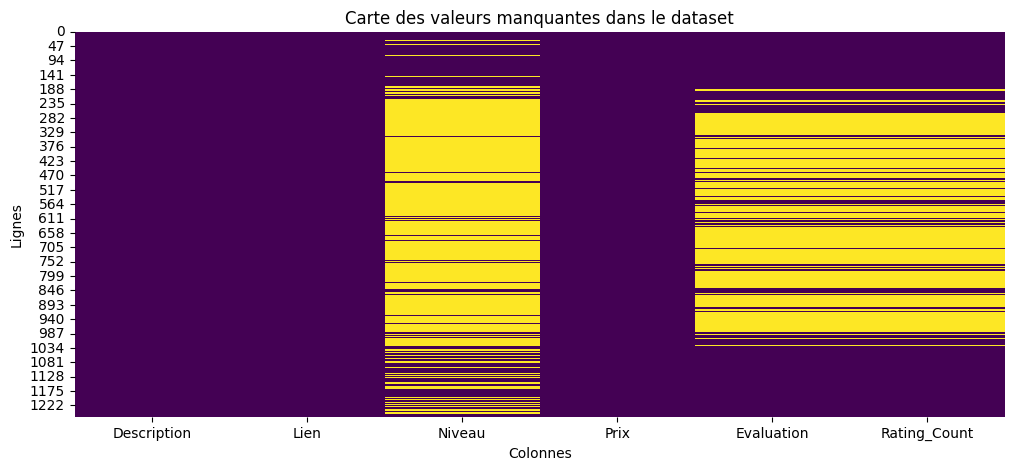

In [107]:
# ➤ Initialise une nouvelle figure matplotlib avec une taille personnalisée (largeur=12, hauteur=5)
plt.figure(figsize=(12, 5))

# ➤ Affiche une carte thermique (heatmap) des valeurs manquantes du DataFrame `df`
# - df.isnull() génère une matrice booléenne : True si la cellule est NaN, False sinon
# - cbar=False désactive la barre de couleur sur le côté droit (inutile ici)
# - cmap='viridis' choisit la palette de couleurs (gradient du noir au vert en passant par le violet)
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# ➤ Ajoute un titre au graphique
plt.title('Carte des valeurs manquantes dans le dataset')

# ➤ Étiquette pour l’axe des x (colonnes du DataFrame)
plt.xlabel("Colonnes")

# ➤ Étiquette pour l’axe des y (chaque ligne représente un échantillon ou une ligne du DataFrame)
plt.ylabel("Lignes")

# ➤ Affiche le graphique final
plt.show()


## 📉 11. Analyse exploratoire initiale du dataset (Suite 3)

### ❓ 11.1. Pourquoi cette étape maintenant ?  

Après avoir repéré les valeurs manquantes globalement, il est pertinent d’**identifier précisément quelles colonnes sont concernées** et dans quelle mesure.  
Cette étape :
- permet de **visualiser rapidement les colonnes les plus problématiques**,
- facilite la **priorisation des traitements** à appliquer (imputation, suppression, transformation…),
- prépare les étapes suivantes de prétraitement.

### 🎯 11.2. Résultat attendu  

#### 📊 Analyse des colonnes incomplètes  
- Un **diagramme en barres horizontales** montrant le **pourcentage de valeurs manquantes** pour chaque colonne concernée (> 0%),
- Une **palette dégradée de rouge** pour visualiser l’importance du taux de valeurs manquantes,
- Un **tri décroissant** pour faire apparaître les colonnes les plus concernées en haut du graphique.

### 🐍 11.3. Script d’analyse exploratoire (Suite 3)

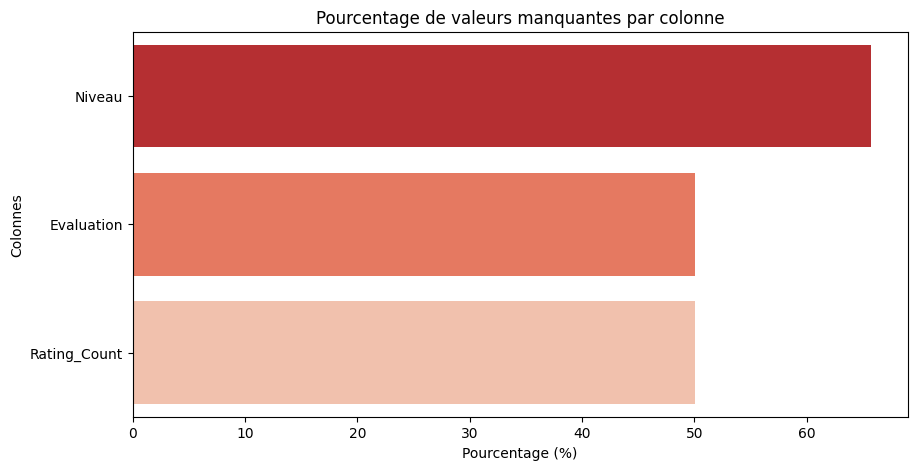

In [108]:
# Visualisation du pourcentage de valeurs manquantes par colonne sous forme de barres horizontales

# Calcule le pourcentage de valeurs manquantes pour chaque colonne
# df.isnull() renvoie un DataFrame booléen : True si NaN, False sinon
# .mean() renvoie la proportion de NaN (True = 1) pour chaque colonne
# Multiplié par 100 pour obtenir un pourcentage
missing_percent = df.isnull().mean() * 100

# Filtre uniquement les colonnes ayant au moins 1 % de valeurs manquantes
# Tri décroissant (ascending=False) pour voir en premier les colonnes les plus touchées
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

# Initialise la taille d'une figure matplotlib
plt.figure(
    figsize=(
        10, # largeur= 10 pouces
        5 # hauteur= 6 pouces
    )
)

# Trace un graphique en barres horizontales avec seaborn :
sns.barplot(
    x=missing_percent.values, # - x = valeurs des pourcentages de NaN
    y=missing_percent.index, # - y = noms des colonnes correspondantes
    hue=missing_percent.index, # chaque barre reçoit une couleur différente
    palette="Reds_r", # - palette="Reds_r" : dégradé de rouge inversé (plus la valeur est élevée, plus la barre est foncée)
    legend=False # on masque la légende (inutile ici)
)

# Ajoute un titre et des étiquettes pour les axes
plt.title("Pourcentage de valeurs manquantes par colonne")
plt.xlabel("Pourcentage (%)")
plt.ylabel("Colonnes")

# Affiche le graphique
plt.show()

---
## 12. Analyse exploratoire initiale du dataset (Suite 4)  

### ❓ 12.1. Pourquoi cette étape maintenant ?  
L'analyse des **valeurs extrêmes (outliers)** est une étape clé avant la modélisation car ces valeurs :
- peuvent **fausser les statistiques globales** (moyenne, écart-type, etc.),
- **perturbent les algorithmes sensibles** aux données extrêmes (ex. : régression linéaire, K-means),
- **révèlent des erreurs** de saisie ou de traitement.

L’objectif ici est de visualiser rapidement ces outliers à l’aide de **boxplots** pour décider d’une stratégie adaptée : les conserver, les corriger ou les supprimer.

### 🎯 12.2. Résultat attendu  

#### 12.2.1. Analyse des valeurs extrêmes (outliers)  
Nous allons générer 3 **boxplots horizontaux** pour analyser la distribution des variables numériques suivantes :
- **Prix**
- **Evaluation**
- **Rating_Count**

Chaque graphique sera **zoomé sur une plage réaliste** pour faciliter la détection des valeurs aberrantes sans être noyé par les extrêmes trop éloignés.

### 🐍 12.3. Script d'analyse exploratoire (Suite 4)

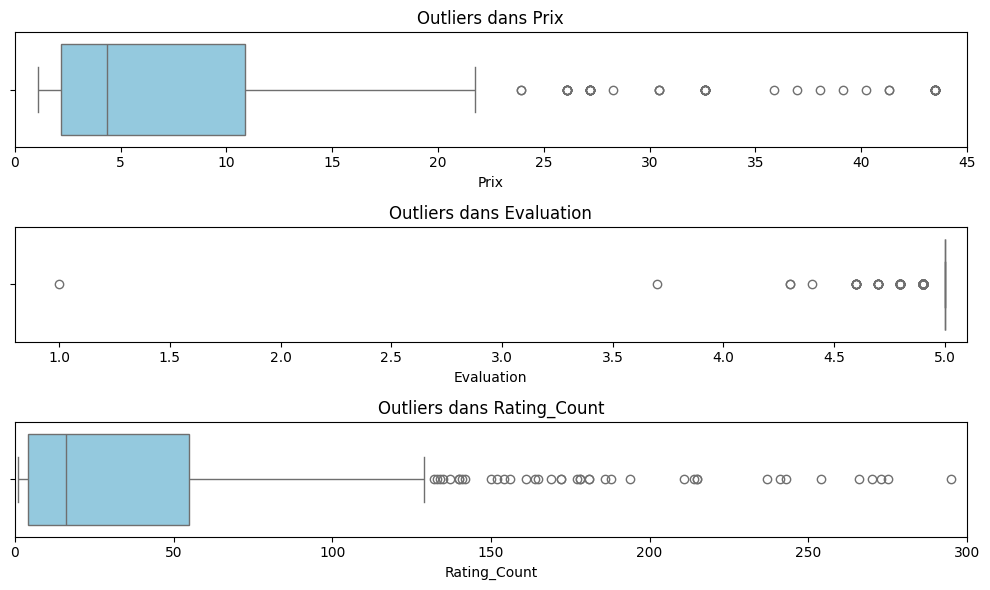

In [109]:
# Liste des colonnes numériques à analyser
numeric_cols = ['Prix', 'Evaluation', 'Rating_Count']

# Définition des plages de valeurs personnalisées pour chaque graphique
# Cela permet d’exclure les valeurs extrêmes (outliers) trop éloignées de la majorité
x_limits = [
    (0, 45),     # Limite d’affichage de l’axe X pour la variable 1, soit 'Prix'
    (0.8, 5.1),  # Limite d’affichage de l’axe X pour la variable 2, soit 'Evaluation'
    (0, 300)     # Limite d’affichage de l’axe X pour la variable 3, soit 'Rating_Count'
]

# Initialisation de la figure matplotlib avec une taille adaptée
plt.figure(
    figsize=(
        10, # largeur= 10 pouces
        6 # hauteur= 6 pouces
    )
)

# Boucle sur chaque colonne numérique et ses limites associées
for i, (col, xlim) in enumerate(zip(numeric_cols, x_limits), 1):
    
    # Création d'une sous-figure, chaque graphique sera placé verticalement l'un sous l'autre
    plt.subplot(
        3, # nombre de lignes
        1, # nombre de colonnes
        i # position du graphique courant (1, 2 ou 3)
    )
    
    # Création du boxplot horizontal (axe X)
    sns.boxplot(
        data=df, # data=df : données source
        x=col, # x=col : on trace la variable numérique en abscisse
        color="skyblue" # color="skyblue" : couleur bleue claire pour la lisibilité
    )
    
    # Définition des limites de l’axe X (zoom sur la partie centrale des données)
    plt.xlim(xlim)
    
    # Ajout d’un titre spécifique à chaque graphique
    plt.title(f"Outliers dans {col}")

# Optimisation de l’espacement entre les sous-graphiques pour éviter les chevauchements
plt.tight_layout()

# Affichage final des visualisations
plt.show()


---
## 13. Analyse exploratoire initiale du dataset (Suite 5)  

### ❓ 13.1. Pourquoi cette étape maintenant ?  
Après avoir identifié les valeurs extrêmes via les boxplots, il est essentiel d’analyser la **distribution générale** de chaque variable numérique pour :
- comprendre leur **répartition globale** (normale, biaisée, aplatie…),
- détecter la **présence de pics, de creux ou de concentrations**,
- préparer le terrain pour un **scaling**, une **transformation** ou une **modélisation adaptée**.

### 🎯 13.2. Résultat attendu  

#### 13.2.1. Analyse de distribution des variables numériques  
Pour chaque variable numérique (`Prix`, `Evaluation`, `Rating_Count`), un **histogramme horizontal** est généré.  
Ces visualisations montrent le **nombre d’observations** dans chaque intervalle de valeur et permettent de :
- visualiser les **zones de densité**,
- anticiper les besoins de **normalisation ou transformation**,
- mettre en évidence d’éventuels **biais ou distributions atypiques**.

### 🐍 13.3. Script d'analyse exploratoire (Suite 5)

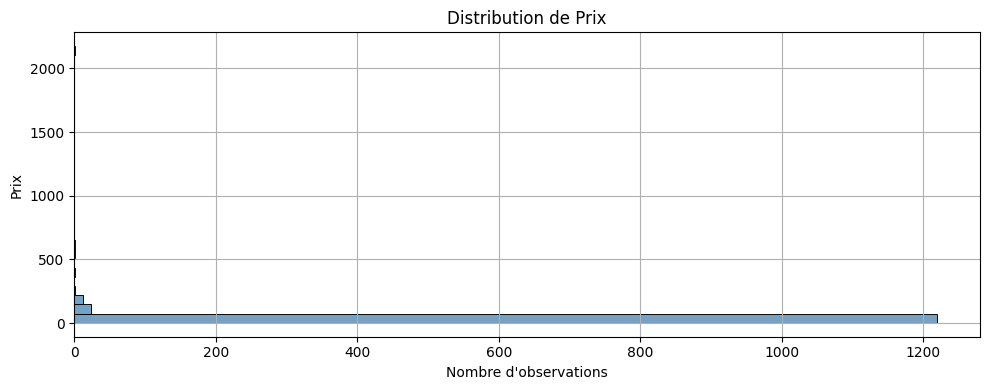

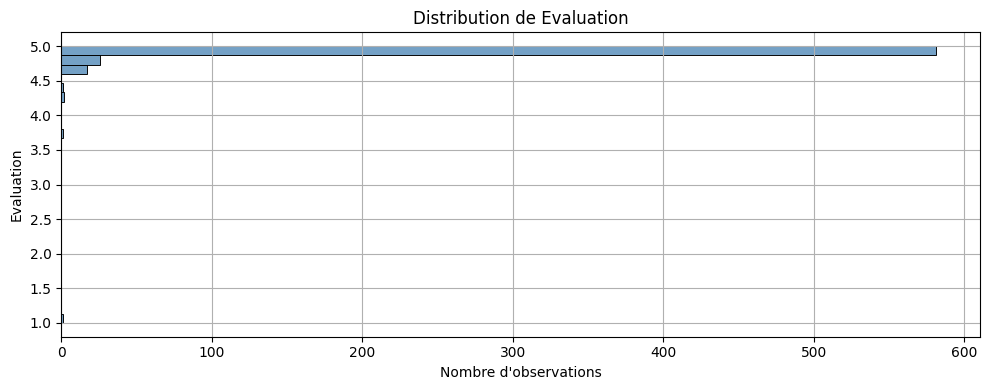

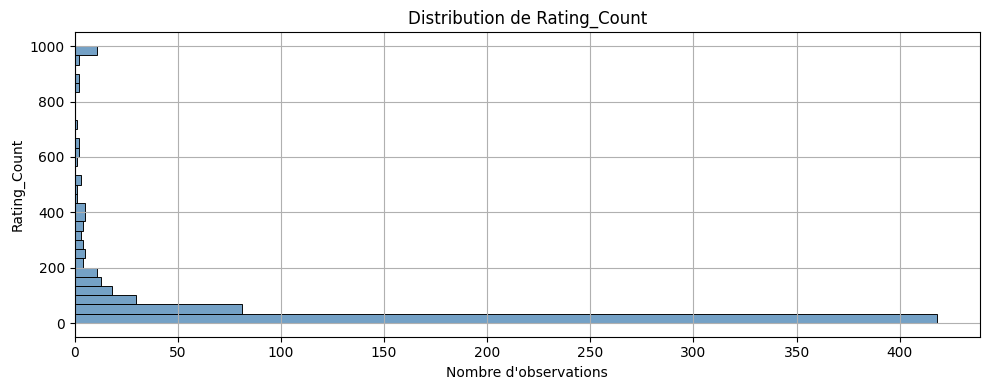

In [110]:
# Histogrammes personnalisés par variable numérique

# Pour chaque colonne numérique dans la liste `numeric_cols`
for col in numeric_cols:
    
    # 1. Création d'une nouvelle figure pour chaque histogramme
    # figsiz définit la taille du graphique
    plt.figure(
        figsize=(
            10, # largeur=10 pouces
            4 #hauteur=4 pouces
        )
    )
    
    # 2. Tracé de l'histogramme avec seaborn
    # sns.histplot permet de tracer des histogrammes :
    sns.histplot(
        data=df, # data=df : on indique le DataFrame source
        y=col, # y=col : on spécifie la variable à afficher sur l’axe vertical (donc histogramme horizontal)
        bins=30, # bins=30 : on divise la variable en 30 classes pour une meilleure résolution
        color='steelblue', # color='steelblue' : couleur des barres
        edgecolor='black' # edgecolor='black' : contour noir pour bien délimiter les barres
    )
    
    # 3. Titre du graphique
    plt.title(f"Distribution de {col}")
    
    # 4. Étiquettes des axes
    plt.ylabel(col)  # l'axe vertical représente les valeurs de la variable
    plt.xlabel("Nombre d'observations")  # l'axe horizontal représente la fréquence
    
    # 5. Affichage de la grille pour faciliter la lecture
    plt.grid(True)
    
    # 6. Ajustement automatique des marges pour éviter les chevauchements
    plt.tight_layout()
    
    # 7. Affichage final du graphique
    plt.show()


---

## 14. Analyse exploratoire initiale du dataset (Suite 6)  

### ❓ 14.1. Pourquoi cette étape maintenant ?  
Après avoir exploré les variables numériques, il est important d’analyser les **variables catégorielles**, notamment celles qui peuvent servir à regrouper ou filtrer les données dans les étapes suivantes.  
La variable `Niveau` (niveau de vendeur) est une **variable de segmentation importante** dans les analyses de marché ou de performance.

### 🎯 14.2. Résultat attendu  

#### 14.2.1. Analyse de la répartition des niveaux de vendeur  (variables catégorielles)
Cette analyse permet de :
- visualiser **le nombre de gigs proposés** par chaque type de vendeur (`Nouveau`, `Confirmé`, `Top Vendeur`, etc.),
- détecter une **éventuelle sur-représentation** d’un niveau,
- préparer des **analyses comparatives par niveau** (prix, avis, etc.).

### 🐍 14.3. Script d'analyse exploratoire (Suite 6)

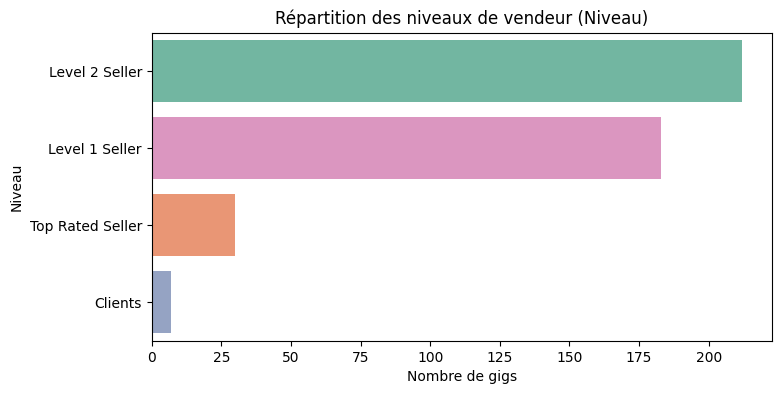

In [111]:
# Visualisation de la répartition des niveaux de vendeurs dans la variable 'Niveau'

# 1. Création d'une nouvelle figure

plt.figure(figsize=(8, 4)) # figsize=(8, 4) : définit la taille de l’image (largeur = 8 pouces, hauteur = 4 pouces)

sns.countplot(
    data=df, # - data=df : le DataFrame source contenant les données
    y='Niveau', # - y='Niveau' : l’axe vertical affiche les catégories de vendeurs (Niveau), les barres sont donc horizontales
    hue='Niveau', # - hue='Niveau' : ajoute une variable de couleur, ici identique à y, pour permettre l’usage d’une palette → évite le FutureWarning de seaborn
    palette='Set2', # - palette='Set2' : palette de couleurs personnalisée (Set2 = tons doux et contrastés)
    order=df['Niveau'].value_counts().index, # - order=df['Niveau'].value_counts().index : trie les niveaux du plus fréquent au moins fréquent
    legend=False # - legend=False : désactive la légende car elle serait redondante (hue et y sont identiques)
)

# 3. Titre du graphique
plt.title("Répartition des niveaux de vendeur (Niveau)")

# 4. Étiquettes des axes
plt.xlabel("Nombre de gigs")   # Axe des X → quantité d’occurrences
plt.ylabel("Niveau")           # Axe des Y → catégories de vendeur

# 5. Affichage du graphique
plt.show()



## 15. Imputation des valeurs manquantes dans les colonnes numériques  

### ❓ 15.1. Pourquoi cette étape maintenant ?  
Après avoir visualisé la distribution des valeurs manquantes et analysé les variables concernées, il est temps de **traiter directement les cellules NaN** pour éviter tout blocage dans les étapes suivantes (modélisation, calculs statistiques, ou visualisations).

Les colonnes `Prix`, `Evaluation`, et `Rating_Count` sont toutes **numériques et susceptibles de contenir des valeurs manquantes**.  
Plutôt que de les remplacer arbitrairement par une moyenne globale, on applique une stratégie d’**imputation intelligente** basée sur les données les plus proches.

### 🎯 15.2. Résultat attendu  

#### 15.2.1. Remplissage des valeurs manquantes dans "Niveau" par KNN  
Grâce à l’imputation par les **K plus proches voisins (KNN)** :
- Les cellules vides sont remplacées par des **valeurs estimées de manière contextuelle**, en s’appuyant sur des gigs similaires.
- Le DataFrame ne contient plus de `NaN` dans les colonnes sélectionnées.
- Les colonnes `Prix`, `Evaluation`, `Rating_Count` deviennent **entièrement exploitables** pour la suite de l’analyse ou du modèle.

### 🐍 15.3. Script de remplissage des valeurs manquantes dans "Niveau" par KNN

In [ ]:
# 1. Sélection des colonnes numériques concernées par l’imputation
# On choisit ici les colonnes susceptibles de contenir des valeurs manquantes
# et sur lesquelles l’imputation par la moyenne des voisins a du sens.
cols_for_impute = ['Prix', 'Evaluation', 'Rating_Count']

# 2. Création d’une copie temporaire du DataFrame contenant uniquement ces colonnes
# Cela évite d’altérer accidentellement d’autres colonnes du DataFrame original.
df_impute = df[cols_for_impute].copy()

# 3. Initialisation du KNNImputer avec k=5
# Cela signifie que, pour chaque valeur manquante, l’algorithme utilisera la moyenne
# des 5 observations les plus proches (selon la distance euclidienne) dans les colonnes spécifiées.
imputer = KNNImputer(n_neighbors=5)

# 4. Application de l’imputation sur les colonnes sélectionnées
# Le résultat est un tableau NumPy où les valeurs manquantes ont été remplacées.
df_imputed = imputer.fit_transform(df_impute)

# 5. Remplacement des anciennes colonnes dans le DataFrame d’origine
# On écrase les colonnes initiales avec les colonnes imputées (sans valeurs manquantes désormais).
df[cols_for_impute] = df_imputed


---
## 16. Imputation des valeurs manquantes dans la colonne "Niveau" (KNN + encodage) 

### ❓ 16.1. Pourquoi cette étape maintenant ?  

Après avoir nettoyé les colonnes numériques et imputé les valeurs manquantes associées, il est logique de s’attaquer aux colonnes **catégorielles** restantes.  
La colonne `Niveau` contient des informations cruciales sur la **qualification du vendeur** (Niveau 1, Niveau 2, Top Rated, etc.), mais certaines entrées sont manquantes.  

Plutôt que de remplacer ces valeurs par la **modalité la plus fréquente** (ce qui pourrait introduire un biais), on utilise une méthode **contextuelle et intelligente** d’imputation par **K plus proches voisins (KNN)**.  
Cette méthode repose sur l'idée que deux vendeurs ayant des caractéristiques similaires (`Prix`, `Evaluation`, `Rating_Count`) ont de fortes chances d’avoir un niveau comparable.

---

### 🎯 16.2. Résultat attendu  

- Toutes les lignes avec une valeur manquante dans la colonne `Niveau` sont complétées.
- L’imputation s’appuie sur des variables pertinentes, évitant les remplacements arbitraires.
- La variable `Niveau` est **entièrement reconstruite** avec des catégories cohérentes.
- Le DataFrame est **nettoyé et prêt** pour la suite de l’analyse ou l’entraînement d’un modèle.

---

### 🐍 16.3. Script d'Imputation

In [ ]:
# 🧠 Imputation de la colonne catégorielle 'Niveau' via KNN (encodage + prédiction)

# Étape 1️ : Encodage temporaire des valeurs non nulles de la colonne 'Niveau'
le = LabelEncoder()  # Crée un encodeur pour convertir les labels texte en entiers

# Initialisation de la colonne encodée avec un type 'float' (car KNNImputer exige des valeurs numériques)
df['Level_encoded'] = pd.Series(dtype='float')

# Création d'un masque pour ne sélectionner que les lignes où 'Niveau' n'est pas manquant
non_null_mask = df['Niveau'].notnull()

# Application de l'encodage sur les lignes non nulles uniquement
# Cela évite une erreur si l'on tente d'encoder des NaN
df.loc[non_null_mask, 'Level_encoded'] = le.fit_transform(df.loc[non_null_mask, 'Niveau'])

# Étape 2️ : Préparation des données pour l’imputation
# On sélectionne les colonnes numériques qui serviront à prédire la variable 'Level_encoded'
# Ces colonnes doivent être cohérentes avec les facteurs explicatifs.
cols_for_knn = ['Prix', 'Evaluation', 'Rating_Count', 'Level_encoded']
df_knn = df[cols_for_knn].copy()

# Étape 3️ : Application de l’imputation KNN
imputer = KNNImputer(n_neighbors=5)  # Utilise les 5 voisins les plus proches
df_imputed = imputer.fit_transform(df_knn)  # Applique l’imputation et retourne un tableau numpy

# Conversion du tableau numpy résultant en DataFrame pour faciliter le réaffectation dans df
df_knn_imputed = pd.DataFrame(df_imputed, columns=cols_for_knn)

# Étape 4️ : Post-traitement – Inversion de l'encodage
# On arrondit les valeurs imputées de 'Level_encoded' (car ce sont des catégories)
# Puis on reconvertit les entiers en labels d'origine grâce à 'inverse_transform'
df['Level_encoded'] = df_knn_imputed['Level_encoded'].round().astype(int)
df['Niveau'] = le.inverse_transform(df['Level_encoded'])

# Étape 5️ : Nettoyage – Suppression de la colonne intermédiaire
df.drop(columns='Level_encoded', inplace=True)

print("Imputation de la colonne 'Niveau' terminée avec succès !")


Imputation de la colonne 'Niveau' terminée avec succès !


# Vérification des valeurs np.nan post imputation

c:\wamp64\www\ia.follaco.fr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


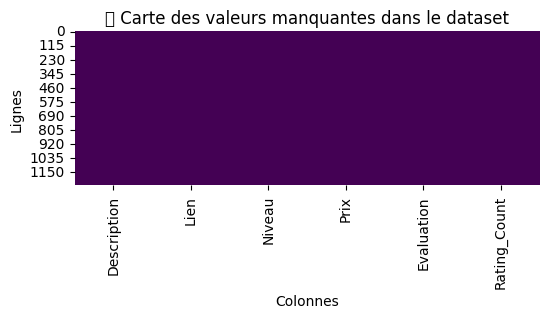

In [114]:
plt.figure(figsize=(6, 2))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('🌡️ Carte des valeurs manquantes dans le dataset')
plt.xlabel("Colonnes")
plt.ylabel("Lignes")
plt.show()

---
## 17. Nettoyage des données

### ❓ 17.1. Pourquoi cette étape maintenant ?  

À ce stade, les valeurs manquantes ont été traitées, les types de données corrigés et les variables clés sont prêtes pour l’analyse.  
Cependant, les **colonnes de type texte** (type `object`) peuvent contenir des **espaces en trop** (avant ou après les mots), ce qui fausse :

- les opérations de filtrage ou de groupement (`groupby`),
- la détection de doublons,
- les futurs encodages de variables catégorielles.

Cette étape assure une **standardisation des chaînes de caractères** avant toute modélisation ou visualisation.

### 🎯 17.2. Résultat attendu  

- Toutes les colonnes de type `object` sont nettoyées des **espaces superflus** en début et en fin de chaîne.
- Les valeurs textuelles sont prêtes pour les étapes d’analyse, de regroupement ou de vectorisation.
- Aucun espace parasite ne viendra perturber l’analyse statistique ou la modélisation.

### 🐍 17.3. Script de nettoyage

In [115]:
# Boucle sur toutes les colonnes de type "object" (généralement chaînes de caractères)
for col in df.select_dtypes(include='object').columns:
    
    # .astype(str) : Convertit chaque cellule en chaîne de caractères (au cas où certains types seraient mixtes ou contiendraient des NaN)
    # .str.strip() : Supprime les espaces en début et en fin de chaîne (mais pas à l’intérieur du texte)
    df[col] = df[col].astype(str).str.strip()

---
## 👀 Aperçu du dataframe après traitement

In [116]:
df.head(2)

,Description,Lien,Niveau,Prix,Evaluation,Rating_Count
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,Level 2 Seller,8.701,5.0,56.0
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,Top Rated Seller,3.263,5.0,1000.0


---
## 18. Visualisation des distributions

### ❓ 18.1. Pourquoi cette étape maintenant ?  

Une fois les données nettoyées et les valeurs manquantes imputées, il est essentiel de **visualiser la répartition des variables numériques**. Cela permet de :

- Comprendre la **forme des distributions** (symétrie, asymétrie, concentration),
- Détecter d’éventuelles **valeurs aberrantes persistantes**,
- Identifier des **zones de densité ou de rareté**,
- Adapter le traitement des variables aux futures étapes (normalisation, discrétisation, etc.).

Cette étape consolide la compréhension globale du dataset avant la phase de modélisation.

### 🎯 18.2. Résultat attendu  

- Un histogramme par variable numérique (`Prix`, `Rating_Count`, `Evaluation`) avec :
  - des limites d’axe personnalisées,
  - un nombre de classes (`bins`) optimisé pour chaque variable,
  - une orientation adaptée (verticale pour `Evaluation`, horizontale pour les autres),
  - une courbe de densité (KDE) superposée pour une meilleure lecture.
- Un **graphique spécial à échelle fractionnée** (broken axis) pour `Evaluation`, utile en cas de distribution fortement déséquilibrée.

### 🐍 18.3. Script de la visualisation des distributions

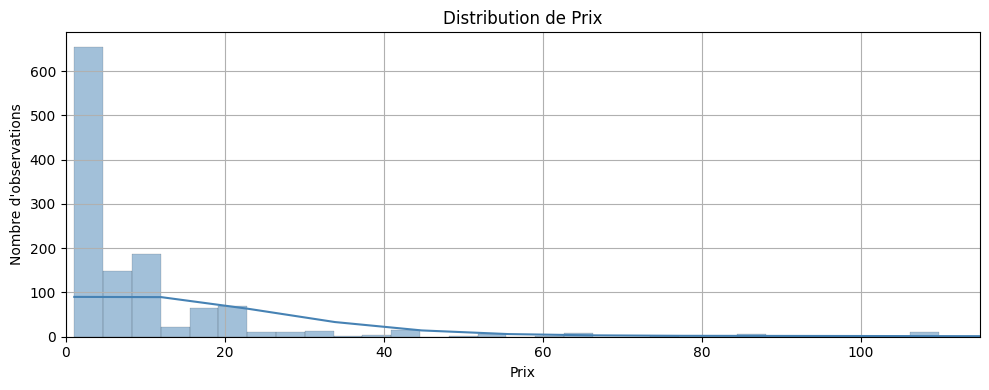

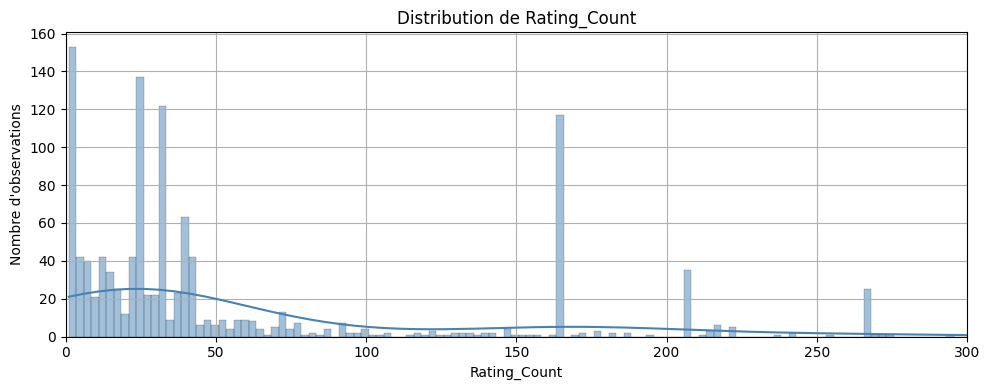

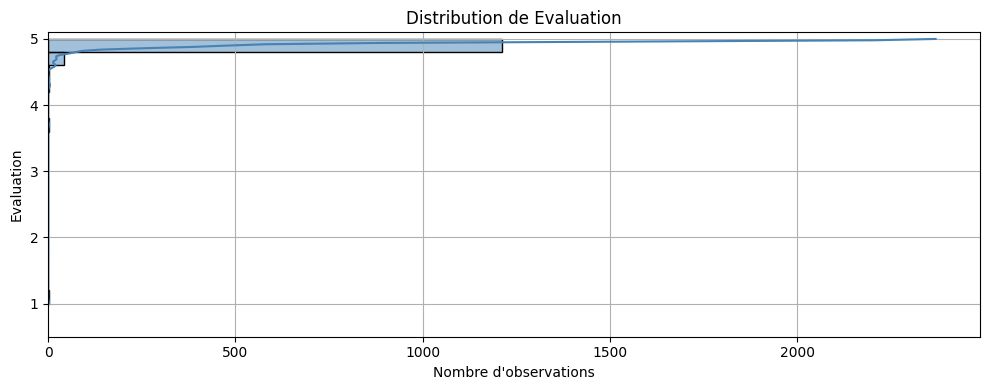

#####################################################################################
Graphique à échelle fractionnée pour la distribution d'évaluation
#####################################################################################


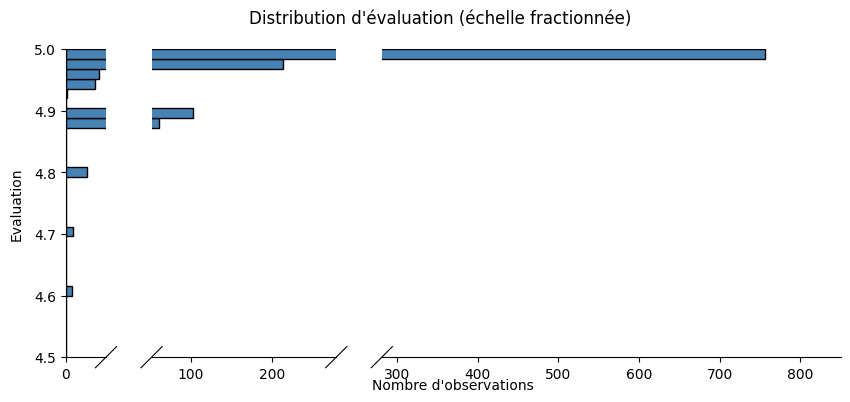

In [117]:
# 📌 Affichage des histogrammes avec orientation personnalisée + échelle fractionnée

# 1️ Colonnes numériques à analyser
numerical_cols = ['Prix', 'Rating_Count', 'Evaluation']

# 2️ Définition de limites d’axes pour une lecture plus précise
x_limits = {
    'Prix': (0, 115),           # Plafond adapté à la distribution de Prix
    'Rating_Count': (0, 300),    # Zoom sur les valeurs les plus fréquentes
    'Evaluation': (0.5, 5.1)   # Échelle cohérente avec le système de notation
}

# 3️ Définition du nombre de classes (bins) pour chaque variable
bins_dict = {
    'Prix': 600,
    'Rating_Count': 400,
    'Evaluation': 20
}

# 4️ Boucle sur chaque variable pour afficher un histogramme
for col in numerical_cols:
    plt.figure(figsize=(10, 4))  # Taille de chaque graphique

    # Cas spécifique : Evaluation → affichage vertical
    if col == 'Evaluation':
        sns.histplot(
            data=df,
            y=col,                         # Axe vertical
            kde=True,                      # Courbe de densité
            bins=bins_dict.get(col, 30),   # Nombre de classes
            color='steelblue',
            edgecolor='black'
        )
        plt.ylabel(col)
        plt.xlabel("Nombre d'observations")
        if col in x_limits:
            plt.ylim(x_limits[col])        # Applique les limites de l’axe Y

    # Autres cas → affichage horizontal classique
    else:
        sns.histplot(
            data=df,
            x=col,                         # Axe horizontal
            kde=True,
            bins=bins_dict.get(col, 30),
            color='steelblue',
            edgecolor='black'
        )
        plt.xlabel(col)
        plt.ylabel("Nombre d'observations")
        if col in x_limits:
            plt.xlim(x_limits[col])        # Applique les limites de l’axe X

    # Mise en forme
    plt.title(f"Distribution de {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

########################################################################
# Graphique de Evaluation avec échelle X fractionnée (Broken Axis)
########################################################################

# Nettoyage des données
data = df['Evaluation'].dropna()

# Figure avec "broken X-axis" (utile si les données sont très déséquilibrées)
fig = plt.figure(figsize=(10, 4))
bax = brokenaxes(xlims=((0, 50), (51, 280), (281, 850)), hspace=0.05)

# Affichage du graphique orienté verticalement (Evaluation sur l’axe Y)
bax.hist(
    data,
    bins=250,
    orientation='horizontal',
    color='steelblue',
    edgecolor='black'
)

# Personnalisation des axes
bax.set_ylabel("Evaluation")
bax.set_xlabel("Nombre d'observations")
bax.set_yticks(np.arange(4.5, 5.1, 0.25))  # Ticks Y de 4.5 à 5.0 avec pas de 0.1
bax.set_ylim(4.5, 5)                      # Limite Y concentrée sur la zone utile

# Titre du graphique
fig.suptitle("Distribution d'évaluation (échelle fractionnée)")

print("#####################################################################################")
print("Graphique à échelle fractionnée pour la distribution d'évaluation")
print("#####################################################################################")

plt.show()


---
## 19. Export du fichier nettoyé

### ❓ 19.1. Pourquoi cette étape maintenant ?  
Après avoir réalisé l’ensemble des étapes de nettoyage et d’imputation, le DataFrame est désormais **propre, complet et prêt à être exploité**.  
Il est donc essentiel de **sauvegarder ce jeu de données nettoyé** pour :

- Éviter de refaire les traitements à chaque exécution,
- Pouvoir partager les données prêtes à l’emploi,
- Faciliter l’analyse ou l’entraînement d’un modèle par la suite.

### 🎯 19.2. Résultat attendu  
- Un fichier CSV nommé `fiverr-data-gigs-cleaned.csv` est généré dans le dossier `data/fiverr_gigs/`.
- Ce fichier contient l’ensemble des données nettoyées sans l’index Pandas.
- Le fichier est encodé en UTF-8 pour assurer sa compatibilité.

### 🐍 19.3. Script de l'export du fichier nettoyé

In [ ]:
# La méthode .to_csv() permet d’enregistrer le contenu du DataFrame 'df' dans un fichier CSV.
# Paramètres :
# - 'data/fiverr_gigs/fiverr-data-gigs-cleaned.csv' : chemin d’accès et nom du fichier de sortie
# - index=False : on ne sauvegarde pas l’index du DataFrame (souvent inutile dans un CSV)
# - encoding='utf-8' : encodage des caractères pour assurer la compatibilité avec les systèmes et logiciels

df.to_csv('data/fiverr-data-gigs-cleaned.csv', index=False, encoding='utf-8')

# Message de confirmation
# On affiche un message dans la console pour indiquer que l’export a bien été effectué
print("✅ Données exportées dans 'data/fiverr_gigs/fiverr_cleaned.csv'")

✅ Données exportées dans 'data/fiverr_gigs/fiverr-data-gigs-cleaned.csv'


---
## 🧾 Conclusion du prétraitement

Ce notebook a permis de préparer le jeu de données "Fiverr Gigs" pour une future phase de modélisation, en assurant la qualité, la cohérence et la lisibilité des informations.

🔧 Étapes clés réalisées :
* Exploration initiale du dataset : dimensions, types, valeurs manquantes, doublons
* Nettoyage des colonnes textuelles et numériques (prix, chaînes de caractères…)
* Imputation rigoureuse des valeurs manquantes par la méthode des K plus proches voisins (KNN), adaptée aussi bien aux variables numériques qu’à la variable catégorielle Niveau
* Analyses visuelles ciblées : heatmaps, boxplots, histogrammes orientés, échelles fractionnées
* Préparation finale des données pour la modélisation : types cohérents, valeurs complètes, format CSV propre

🎯 Résultat :
Les données sont désormais prêtes à être utilisées pour des analyses statistiques avancées ou des modèles de machine learning.

---
## ✅ Checklist de fin de prétraitement des données

| Étape                                   | Description                                                                                                 | Statut       |
| --------------------------------------- | ----------------------------------------------------------------------------------------------------------- | ------------ |
| 📥 **Téléchargement du dataset**        | Téléchargement automatisé depuis Kaggle avec `kagglehub`                                                    | ✅            |
| 📂 **Chargement du fichier CSV**        | Chargement dans un DataFrame avec encodage `utf-8`                                                          | ✅            |
| 🧽 **Renommage des colonnes**           | Nettoyage des noms, suppression des caractères parasites (ex. `ï»¿`)                                        | ✅            |
| 🧹 **Nettoyage des chaînes**            | Suppression des espaces en début/fin avec `.str.strip()`                                                   | ✅            |
| 🏷️ **Conversion des types**            | Colonnes `Prix`, `Evaluation`, `Rating_Count` converties en `float`                                         | ✅            |
| 💶 **Nettoyage des prix**               | Suppression des symboles (€/$), remplacement des virgules par des points                                    | ✅            |
| ❌ **Suppression de colonnes inutiles** | Suppression de la colonne `gigrating` jugée non pertinente                                                  | ✅            |
| 🔎 **Analyse exploratoire initiale**    | Dimensions, types, NA, doublons, unicité des valeurs                                                        | ✅            |
| 📊 **Visualisation des distributions**  | Histogrammes des variables numériques + zoom sur `Evaluation`                                               | ✅            |
| 📈 **Analyse des niveaux vendeurs**     | Countplot des modalités de la variable `Niveau`                                                             | ✅            |
| 🧪 **Détection des outliers**           | Visualisation avec boxplots des variables numériques                                                        | ✅            |
| 🧠 **Imputation KNN - Numérique**       | KNN Imputer (k=5) sur `Prix`, `Evaluation`, `Rating_Count`                                                  | ✅            |
| 🧠 **Imputation KNN - Catégorielle**    | Encodage + KNN Imputer sur la colonne `Niveau`, puis décodage inverse                                      | ✅            |
| ✏️ **Nettoyage final des chaînes**      | Harmonisation de tous les champs texte avant export                                                        | ✅            |
| 💾 **Export du fichier nettoyé**        | Sauvegarde en `.csv` avec `utf-8` sans index, prêt pour le ML                                               | ✅            |
